# **Задание Ultra Lite**

Перепишите кластеризацию базы покупок интернет-магазина из ноутбука занятия (можно подсматривать в ноутбук, но желательно всё напечатать самому).

Сделайте кластеризацию на 5, 50, 500 кластеров. Сравните время разбиения. Напишите выводы.

# Подключение библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Кластеризация корзин интернет-магазина**

## **Работа с таблицей**

### Загрузка базы

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/УИИ/Кластеризация/online_carts.csv')

### Редактирование базы

In [ ]:
# Просмотр таблицы
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


### Посмотрим на уникальные значения каждого из безымянных столбцов

In [ ]:
print(df['Unnamed: 0'].unique())

[nan]


In [ ]:
print(df['Unnamed: 2'].unique())

[nan ' Количество(Базовых ед.)' ' ЗаказПокупателя.ID заказа (Элементы)'
 ... '3472' '7616' '2731']


In [ ]:
print(df['Unnamed: 3'].unique(), sep='\n')

[nan ' Номенклатура.Наименование (Элементы)' 'Количество' 'Базовых ед.'
 '9' '1' '4' '797' '162' '3' '2' '5' '7' '8' '6' '49' '10' '34' '11' '25'
 '20' '13' '17' '29' '1130' '148' '12' '40' '14' '50' '68' '51' '23' '22'
 '16' '1096' '105' '124' '139' '19' '15' '26' '30' '21' '504' '28' '575'
 '60' '61' '18' '80' '942' '44' '188' '24' '1375' '147' '137' '33' '597'
 '82' '37' '860' '47' '825' '27' '45' '229' '887' '113' '58' '104' '38'
 '1751' '134' '138' '1214' '341' '168' '81' '88' '1074' '150' '32' '52'
 '43' '1023' '64' '72' '31' '39' '1237' '254' '46' '289' '1938' '456'
 '132' '2689' '599' '1771' '181' '322' '77' '556' '90' '256' '42' '57'
 '35' '883' '118' '1078' '145' '2749' '36' '1360' '85' '893' '214' '692'
 '119' '1533' '239' '650' '93' '70' '1551' '158' '78' '102' '780' '291'
 '41' '1278' '140' '48' '161' '1127' '122' '94' '978' '98' '769' '92'
 '159' '720' '69' '56' '1648' '688' '752' '108' '174' '850' '172' '848'
 '117' '151' '1511' '665' '278' '84' '1216' '243' '1057' '295'

In [ ]:
print(df['Unnamed: 4'].unique())

[nan  1.  4.  2.]


### Удаление ненужного столбца

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head(2)

,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN


### Добавление новой колонки Дата и изменение NaN на unknown

In [ ]:
# Чтобы из базы вытащить временные данные в отдельную колонку
df.insert(0, column='Дата', value=[x for x in range(len(df))])

df = df.fillna('unknown')

df.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,2,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,3,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,4,unknown,unknown,unknown,unknown


### Создание флага начала корзины и изменнение значений в столбце **Дата**

In [ ]:
# Series.str.contains() содержится ли шаблон в строке, присутствующей в базовых данных данного объекта серии.

df[df['Валовая прибыль'].str.contains('MCOSM')].head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown


In [ ]:
df['Валовая прибыль'].str.contains('MCOSM').head()

0    False
1    False
2    False
3    False
4    False
Name: Валовая прибыль, dtype: bool

In [ ]:
# Индексы строк, где есть информация в формате даты
date_list = list(df[df['Валовая прибыль'].str.contains('\d\d.\d\d.2019')].index)
# Пример индексов
print(date_list[:10])

[9, 21, 28, 703, 1703, 2617, 3067, 3538, 4344, 5524]


In [ ]:
idx = 0

for i in range(len(df)):
  if i in date_list:
    idx = i
  df['Дата'][i] = df['Валовая прибыль'][idx]

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,Период: Февраль 2019 г. - Август 2019 г.,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,Период: Февраль 2019 г. - Август 2019 г.,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,Период: Февраль 2019 г. - Август 2019 г.,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown,unknown


### Дальнейшая очистка таблицы

In [ ]:
# Первые строки где есть слово - Период
df = df.drop(df[df['Дата'].str.contains('Период')].index, axis=0)

In [ ]:
# Пустые строки между корзинами
df = df.drop(df[df['Валовая прибыль'].str.contains('unknow')].index, axis=0)

In [ ]:
# Строки-даты, которые находятся в столбце корзин
# Это тот же список data_list
df = df.drop(df[df['Валовая прибыль'] == df['Дата']].index)

In [ ]:
# Обновление индекса
df.reset_index(inplace=True)

In [ ]:
df = df.drop('index', axis=1)

In [ ]:
df.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


### Индексы строк, содержания флага MCOSM и CAFRE

In [ ]:
cart_list  = list(df[df['Валовая прибыль'].str.contains('MCOSM')].index)
cafre_list = list(df[df['Валовая прибыль'].str.contains('CAFRE')].index)

In [ ]:
print(cart_list[:10])
print(cafre_list[:10])

[0, 10, 151, 153, 157, 163, 172, 178, 182, 187]
[115, 794, 1743, 2620, 2624, 2639, 6007, 7451, 7458, 7464]


## **Создание корзин**

In [ ]:
# Список всех корзин
carts = []

cart = []                   # Текущая карзина
i = 0                       # Счетчик для прохождения по базе
val = df['Валовая прибыль'] # Будем работать с этим столбцом - Валовая прибыль
allPositions = []           # Пустой список позиций

while i != len(df):
  if i in cart_list:
    if i != cart_list[-1]:  # Если не последний индекс-флаг
      ind = cart_list.index(i)

      while i < cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1])
        i += 1
    else:                     # Если же текущий индекс-флаг последний в списке
      while i <(len(df)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1])
        i += 1
  
    carts.append(cart)
    cart=[]
  else:
    i += 1

In [ ]:
# Проверка
print(len(carts)==len(cart_list))
print('Количество всех позиций: ', len(allPositions))
print()

 # Пример того, что лежит в корзине
for i in carts[0]:
  print(i)

True
Количество всех позиций:  85617

CONTURA (HS61) машинка для стрижки волос
Holika Holika Универсальный гель 99% алоэ вера, 250 мл
Kapous Бальзам-уход для придания объема Volume up 350 мл
Kapous Шампунь для придания объема Volume up 350 мл
XPERT (HS71) машинка для стрижки волос
ЛП ТНА САВАЖ ПАНАШ 250 мл
перчатки (50 пар) винил размер S черные
Услуга доставки DPD до двери
Услуга доставки СДЭК


### **Гистограмма** размера корзин

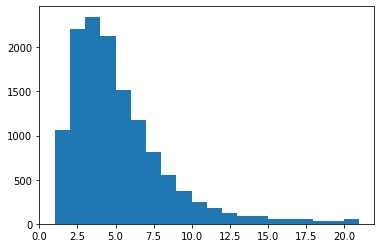

In [ ]:
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

## **LabelEncoder**

In [ ]:
labelEncoder = LabelEncoder()
labelEncoder.fit(allPositions)

LabelEncoder()

In [ ]:
type(labelEncoder)

sklearn.preprocessing._label.LabelEncoder

### Количество уникальных товаров 

In [ ]:
maxPositionsCount = max(labelEncoder.transform(allPositions)) + 1
print(maxPositionsCount)

6663


### Создание списока индексов для каждой корзины

In [ ]:
cartsIndexes = [labelEncoder.transform(c) for c in carts]

In [ ]:
type(cartsIndexes)

list

In [ ]:
n = 100
print(carts[n])
print(cartsIndexes[n])

['Крем для массажа Modelage Active Cream 300 мл.', 'Мультиактивная сыворотка с ретинолом Multi - Action Serum 150 мл.', 'Тоник с фруктовыми кислотами AHA  - Glycolic Tonic 250 мл.', 'Услуга доставки Почта России']
[3808 4607 5573 5659]


## Дополнительные функции

### Функция преобразования вектора

In [ ]:
def changeXTo01(trainVektor, wordsCount):
  out = np.zeros(wordsCount)
  for x in trainVektor:
    out[x] = 1
  return out

### Функция преобразования выборки (обучающей или проверочной)

In [ ]:
def changeSetTo01(trainSet, wordsCount):
  out = []
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
  return np.array(out)

## Создание выборки по принципу **bag of words**

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount)

In [ ]:
# Проверка
n = 100
print(carts[n])
print(cartsIndexes[n])
print(carts01[n])

['Крем для массажа Modelage Active Cream 300 мл.', 'Мультиактивная сыворотка с ретинолом Multi - Action Serum 150 мл.', 'Тоник с фруктовыми кислотами AHA  - Glycolic Tonic 250 мл.', 'Услуга доставки Почта России']
[3808 4607 5573 5659]
[0. 0. 0. ... 0. 0. 0.]


## Кластеризация

### **5** кластеров

In [ ]:
curr_time = time.time()
clustersCount_5 = 5
kmean_5 = KMeans(clustersCount_5)
kmean_5.fit(carts01)                # Кластеризация carts01
labels_5 = kmean_5.labels_          # Сохраняем метки в переменную labels

print(f'Время обработки: {round(time.time() - curr_time,2)}')

Время обработки: 38.73


### **50** кластеров

In [ ]:
curr_time = time.time()
clustersCount_50 = 50
kmean_50 = KMeans(clustersCount_50)
kmean_50.fit(carts01)
labels_50 = kmean_50.labels_

print(f'Время обработки: {round(time.time() - curr_time,2)}')

Время обработки: 184.29


### **500** кластеров

In [ ]:
curr_time = time.time()
clustersCount_500 = 500
kmean_500 = KMeans(clustersCount_500)
kmean_500.fit(carts01)
labels_500 = kmean_500.labels_

print(f'Время обработки: {round(time.time() - curr_time,2)}')

Время обработки: 1448.66


## Отображение меток **50** кластеров

In [ ]:
print(labels_50)

[11 47 11 ... 15 15 27]


In [ ]:
# Создадим список размеров каждого кластера
clusterSize_50 = [sum(labels_50==i) for i in range(0, clustersCount_50)]

In [ ]:
# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize_50):
  print(i, s)

0 231
1 183
2 266
3 1
4 52
5 69
6 213
7 65
8 1
9 51
10 271
11 3534
12 15
13 1
14 25
15 3232
16 308
17 3007
18 1
19 202
20 35
21 1
22 1
23 1
24 1
25 1
26 1
27 795
28 15
29 1
30 1
31 323
32 1
33 3
34 1
35 52
36 6
37 22
38 1
39 1
40 1
41 1
42 1
43 16
44 268
45 58
46 1
47 1
48 228
49 1


### Дополнительные функции для вывода информации

In [ ]:
carts01.shape

(13567, 6663)

In [ ]:
def getCluster(x):
  clasterSize = x.shape[0]
  sumX = np.sum(x, axis=0)
  sumX /= clasterSize

  positions = []
  positionValues = []

  for i in range(sumX.shape[0]):
    if (sumX[i] > 0):
      position = labelEncoder.inverse_transform([i])
      positions.append(position)
      positionValues.append(sumX[i])
  return positions, positionValues

In [ ]:
for clussterNumber in range(len(clusterSize_50)):
  if clusterSize_50[clussterNumber] > 5:
    pos, posVal = getCluster(carts01[labels_50==clussterNumber])
    print("Покупок:", clusterSize_50[clussterNumber])
    print("Позиций:", len(pos))
    pos = np.array(pos)
    posVal = np.array(posVal)
    indexes = posVal > 0.6
    indexedPos = pos[indexes]
    indexedPosVal = posVal[indexes]

    # Отображение
    for i in range(len(indexedPos)):
      print(f"{round(100 * indexedPosVal[i])} % {indexedPos[i]}")
    
    print()
    print("--------------------------------------------------------------------------")

Покупок: 231
Позиций: 876

--------------------------------------------------------------------------
Покупок: 183
Позиций: 803
100 % ['Шампунь для ежедневного применения 1000 мл. Curex Classic']

--------------------------------------------------------------------------
Покупок: 266
Позиций: 610
100 % ['Серебристая маска для холодных оттенков блонд ESTEL PRIMA BLONDE 300 мл.']

--------------------------------------------------------------------------
Покупок: 52
Позиций: 441
65 % ['Бальзам для интенсивного увлажнения волос OTIUM AQUA 200 мл.']
69 % ['Комфорт-маска для интенсивного увлажнения волос OTIUM AQUA 300 мл.']
85 % ['Шампунь для интенсивного увлажнения волос OTIUM AQUA 250 мл.']

--------------------------------------------------------------------------
Покупок: 69
Позиций: 800

--------------------------------------------------------------------------
Покупок: 213
Позиций: 778
100 % ['Скраб антицеллюлитный (выравнивающий) Likato 250мл']

-------------------------------------

In [ ]:
labels_50

array([11, 47, 11, ..., 15, 15, 27], dtype=int32)

## Классы на графике

Готово разбиение на 20 классов
Готово разбиение на 40 классов
Готово разбиение на 60 классов
Готово разбиение на 80 классов
Готово разбиение на 100 классов
Готово разбиение на 120 классов
Готово разбиение на 140 классов
Готово разбиение на 160 классов
Готово разбиение на 180 классов
Готово разбиение на 200 классов
Готово разбиение на 220 классов
Готово разбиение на 240 классов
Готово разбиение на 260 классов
Готово разбиение на 280 классов


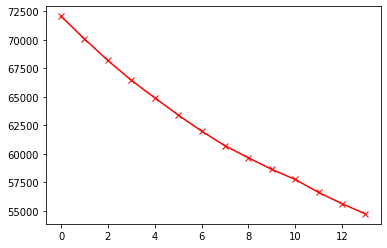

In [ ]:
cost = []
for i in range(1, 15):
  kmean = KMeans(i*20)
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print(f"Готово разбиение на {i*20} классов")

plt.plot(cost, 'rx-')
plt.show()

# Выводы:

1. Код писался в ручную с понимаем процесса и разбора всех неоходимых функций.
2. При кластеризации на разное кол-во кластеров, затрачивало разное время:
 - На 5 кластеров: **38.73** с
 - На 50 кластеров: **184.29** с
 - На 500 кластеров: **1448.66** с
3. Чем больше кол-во кластеров, тем больше требуется время на обработку. 
4. Кластеризация данных помогает для подготовки данных для подачи в нейронную сеть.
